In [2]:
import datetime
import pandas as pd
import numpy as np
import random
import seaborn as sns
import os
from catboost import CatBoostClassifier
from g2net.eda import get_indexed_items, concat_series, merge_iters
from g2net.input import find_files_with_suffix_rooted_at_path, extract_dict_from_df, load_n_samples_with_label
from g2net.pipeline import CkptClassifier, CkptDataLoader, params_to_str
from hyperopt import hp, fmin, tpe
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from typing import Any

# Preparation

## Global Utilities

In [3]:
DATA_SUFFIX = '.npy'

TRAIN_DATA_DIR = 'data\\train'
TRAIN_BATCH_SIZE = 8192
TRAIN_N_BATCH = 8
TRAIN_LABEL_KEY_COL = 'id'
TRAIN_LABEL_VAL_COL = 'target'
EVAL_SAMPLE_SIZE = 1024
TEST_SAMPLE_SIZE = 1024

SUBMIT_DATA_DIR = 'data\\test'

CKPT_PATH = 'checkpoints\\'

LABEL_COL_NAME = 'class_val'
LABEL_VALUES = [0, 1]

CHANNEL_NAMES = ['channel_1', 'channel_2', 'channel_3']
N_CHANNELS = len(CHANNEL_NAMES)
N_TIMESTEPS = 4096

In [4]:
def raw_dataset_to_df(raw_features, raw_labels):
    raw_features_df = pd.DataFrame(raw_features, columns=CHANNEL_NAMES)
    raw_labels_df = pd.DataFrame(raw_labels, columns=[LABEL_COL_NAME])
    return raw_features_df, raw_labels_df

## Collect File Names

In [5]:
train_file_names = find_files_with_suffix_rooted_at_path(
    DATA_SUFFIX, TRAIN_DATA_DIR, TRAIN_BATCH_SIZE * TRAIN_N_BATCH + EVAL_SAMPLE_SIZE + TEST_SAMPLE_SIZE)
train_all_labels_source_df = pd.read_csv('data\\training_labels.csv')
train_all_labels = extract_dict_from_df(train_all_labels_source_df, TRAIN_LABEL_KEY_COL, TRAIN_LABEL_VAL_COL)

In [6]:
submit_file_names = find_files_with_suffix_rooted_at_path(DATA_SUFFIX, SUBMIT_DATA_DIR, None)

# EDA

## Constants

In [7]:
EDA_SAMPLE_SIZE = 1024 * 128
EDA_SAMPLE_TS_COUNT = 1024
EDA_TS_SAMPLE_SIZE = 4

## Loading EDA Data

In [8]:
eda_raw_features, eda_raw_labels = raw_dataset_to_df(*load_n_samples_with_label(
    train_file_names, 
    train_all_labels, 
    0,
    EDA_SAMPLE_TS_COUNT,
    (N_CHANNELS, N_TIMESTEPS),
))

## Distribution Exploration

First thing that stands out is the fact that the signal strength in some of the examples is very low (~10^-22), so first I would like to get an understanding of the signal strength distribution, i.e. mean/variance. 

In [9]:
DS_SAMPLE_IDS = random.sample(range(EDA_SAMPLE_TS_COUNT * N_TIMESTEPS * N_CHANNELS), EDA_SAMPLE_SIZE)

In [10]:
ds_train_timestep_expanded = eda_raw_features.apply(concat_series)
ds_train_channel_expanded = concat_series([ds_train_timestep_expanded[channel] for channel in CHANNEL_NAMES]) * 1e20
ds_train_channels = merge_iters([
    ([channel] * EDA_SAMPLE_TS_COUNT * N_TIMESTEPS) 
    for channel in CHANNEL_NAMES
])
desc_stats_features_map = {
    'data': get_indexed_items(ds_train_channel_expanded, DS_SAMPLE_IDS),
    'channel': get_indexed_items(ds_train_channels, DS_SAMPLE_IDS)
}

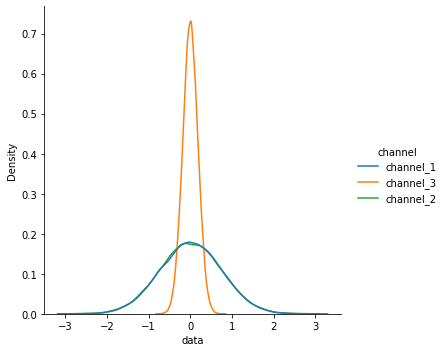

In [11]:
sns.displot(desc_stats_features_map, x='data', hue='channel', kind='kde')

Next it's beneficial to get a feeling of the label landscape.

In [12]:
eda_raw_labels[LABEL_COL_NAME].value_counts()

1    514
0    510
Name: class_val, dtype: int64

## Time Variance

Then we would like to take a look at the time variance of the different channels for a few 0/1 signals.

In [13]:
ds_ts_samples = [
    eda_raw_features[eda_raw_labels[LABEL_COL_NAME] == label_value].sample(n=EDA_TS_SAMPLE_SIZE) * 1e20 
    for label_value in LABEL_VALUES
]

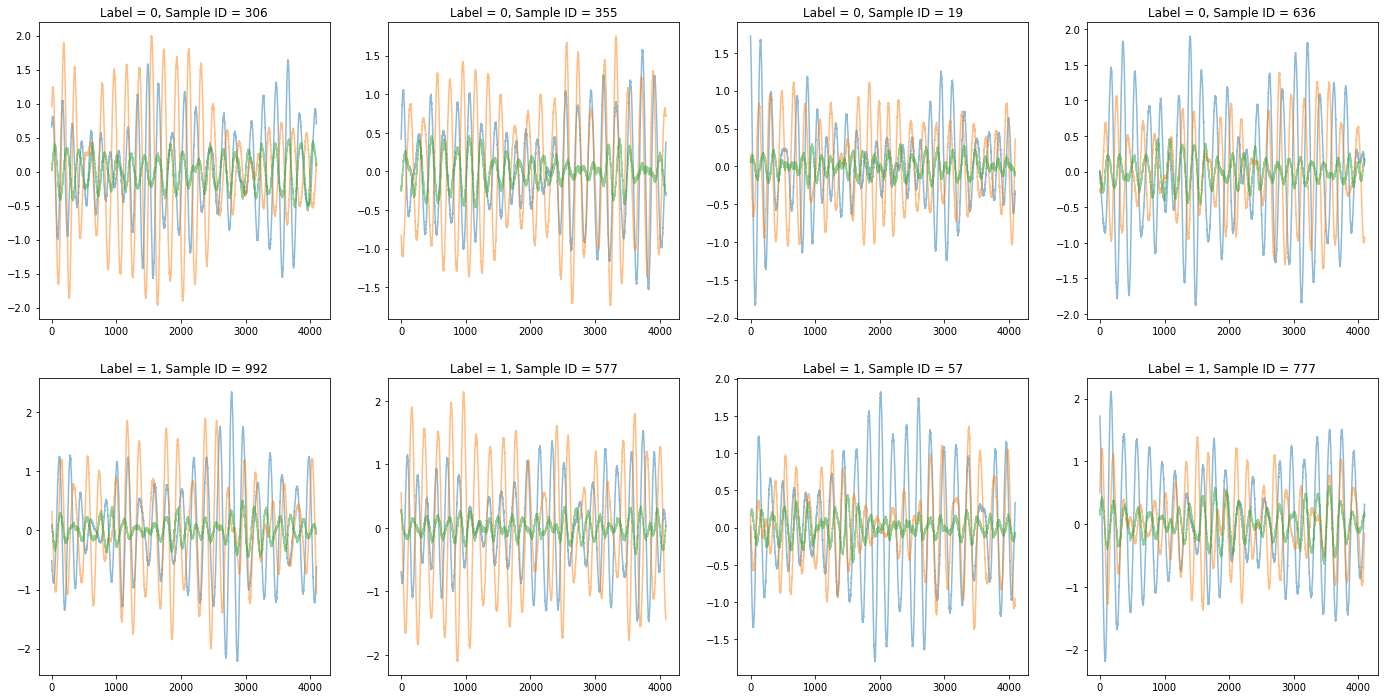

In [14]:
fig, ax = plt.subplots(len(LABEL_VALUES), EDA_TS_SAMPLE_SIZE, figsize=(24, 12))
for label_value in LABEL_VALUES:
    for sample_id in range(EDA_TS_SAMPLE_SIZE):
        for c_id in range(N_CHANNELS):
            sns.lineplot(
                data=ds_ts_samples[label_value].iloc[sample_id, c_id], 
                alpha=0.5, 
                ax=ax[label_value][sample_id]
            ).set_title(f'Label = {label_value}, Sample ID = {ds_ts_samples[label_value].index[sample_id]}')

# Model Selection

## Preprocessing

Here we summarise what we have learned in the EDA step, and apply transformations on our input data accordingly.
Overall the dataset looks pretty clean, so we simply scale the signals up to the 10^0 magnitude.

In [15]:
def scale_pd_series(series: pd.Series) -> pd.Series:
    scaler = StandardScaler()
    reshaped_series = series.to_numpy().reshape(-1, 1)
    scaled_series = scaler.fit_transform(reshaped_series).reshape(-1)
    return pd.Series(scaled_series)

In [16]:
def preprocess(raw_features, raw_labels):
    return raw_features.applymap(scale_pd_series), raw_labels

## Prepare Evaluation and Testing Dataset

In [17]:
eval_raw_features, eval_labels = preprocess(*raw_dataset_to_df(*load_n_samples_with_label(
    train_file_names, 
    train_all_labels, 
    TRAIN_BATCH_SIZE * TRAIN_N_BATCH,
    EVAL_SAMPLE_SIZE,
    (N_CHANNELS, N_TIMESTEPS),
)))

In [18]:
test_raw_features, test_labels = preprocess(*raw_dataset_to_df(*load_n_samples_with_label(
    train_file_names, 
    train_all_labels, 
    TRAIN_BATCH_SIZE * TRAIN_N_BATCH,
    TEST_SAMPLE_SIZE,
    (N_CHANNELS, N_TIMESTEPS),
)))

In [19]:
# Create an iterable dataset for the training data
train_raw_batches = lambda n_batch, batch_size=TRAIN_BATCH_SIZE, ckpt_path=None: CkptDataLoader(
    train_file_names, 
    train_all_labels, 
    n_batch, 
    batch_size, 
    (N_CHANNELS, N_TIMESTEPS),
    ckpt_path
)

## Model Fitting

### Rocket

ROCKET transforms time series using random convolutional kernels (random length, weights, bias, dilation, and padding). ROCKET computes two features from the resulting feature maps: the max, and the proportion of positive values (or ppv). 

In [20]:
# Constants
N_ROCKET_FIT_BATCH = 32

In [21]:
def fit_rocket(rocket, n_batch=N_ROCKET_FIT_BATCH):
     for batch in train_raw_batches(1, n_batch * TRAIN_BATCH_SIZE):
          train_features, _ = preprocess(*raw_dataset_to_df(*batch))
          rocket.fit(train_features)

### Linear Model

In [22]:
def fit_linear(linear_classifier: Any, train_data: CkptDataLoader, rocket: Any, eval_trans_features: pd.DataFrame):
    for batch in train_data:
        train_features, train_labels = preprocess(*raw_dataset_to_df(*batch))
        train_trans_features = rocket.transform(train_features)

        linear_classifier.fit(train_trans_features, train_labels.to_numpy().reshape(-1))

        print(f'[{datetime.datetime.now().strftime("%H:%M:%S")}] Finished running training batch {train_data.batch_id}, '
              f'accuracy on evaluation set: Linear = {linear_classifier.score(eval_trans_features, eval_labels)}')

In [28]:
def training_function_linear(args):
    rocket_args = args['rocket_args']
    linear_args = args['linear_args']
    
    # Initialisation
    search_name = f'{params_to_str(rocket_args)}_{params_to_str(linear_args)}'
    rocket = MiniRocketMultivariate(**rocket_args)
    linear_ckpt_classifier = CkptClassifier(
        LogisticRegression, 
        ckpt_path=os.path.join(CKPT_PATH, f'linear_{search_name}.joblib'), 
        **linear_args
    )

    # Fitting
    fit_rocket(rocket)
    eval_trans_features = rocket.transform(eval_raw_features)
    with linear_ckpt_classifier as linear_classifier:
        with train_raw_batches(TRAIN_N_BATCH, os.path.join(CKPT_PATH, f'linear_data_loader_{search_name}.joblib')) as train_data:
            fit_linear(linear_classifier, train_data, rocket, eval_trans_features)

    # Testing
    test_trans_features = rocket.transform(test_raw_features)
    return linear_classifier.score(test_trans_features, test_labels)

### Gradient Boosting Machine

In [29]:
def fit_gbm(gbm_classifier: Any, train_data: CkptDataLoader, rocket: Any, eval_trans_features: pd.DataFrame):
    for batch in train_data:
        train_features, train_labels = preprocess(*raw_dataset_to_df(*batch))
        train_trans_features = rocket.transform(train_features)
        
        gbm_classifier.fit(train_trans_features, train_labels, eval_set=(eval_trans_features, eval_labels), verbose=False)
        
        print(f'[{datetime.datetime.now().strftime("%H:%M:%S")}] Finished running training batch {train_data.batch_id}, '
              f'accuracy on evaluation set: GBM = {gbm_classifier.score(eval_trans_features, eval_labels)} (best iteration at {gbm_classifier.best_iteration_})')

In [30]:
def training_function_gbm(args):
    rocket_args = args['rocket_args']
    gbm_args = args['gbm_args']

    # Initialisation
    search_name = f'{params_to_str(rocket_args)}_{params_to_str(gbm_args)}'
    rocket = MiniRocketMultivariate(**rocket_args)
    gbm_ckpt_classifier = CkptClassifier(
        CatBoostClassifier, 
        ckpt_path=os.path.join(CKPT_PATH, f'gbm_{search_name}.joblib'), 
        **gbm_args
    )

    # Fitting
    fit_rocket(rocket)
    eval_trans_features = rocket.transform(eval_raw_features)
    with gbm_ckpt_classifier as gbm_classifier:
        with train_raw_batches(TRAIN_N_BATCH, os.path.join(CKPT_PATH, f'gbm_data_loader_{search_name}.joblib')) as train_data:
            fit_gbm(gbm_classifier, train_data, rocket, eval_trans_features)

    # Testing
    test_trans_features = rocket.transform(test_raw_features)
    return gbm_classifier.score(test_trans_features, test_labels)

## Hyperparameter Tuning

In [33]:
SEARCH_SPACE = {
        # Rocket Arguments
        'rocket_args': {
                'num_features': hp.choice('num_features', [10, 100, 1000]), 
                'max_dilations_per_kernel': hp.choice('max_dilations_per_kernel', [32]),
        },
        
        # Logistic Regression Arguments
        'linear_args': {
                'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet']), 
                'tol': hp.loguniform('tol', 1e-5, 1e-3), 
                'C': hp.loguniform('C', 0.1, 10), 
                'fit_intercept': hp.choice('fit_intercept', [False, True]), 
                'intercept_scaling': hp.loguniform('intercept_scaling', 0.1, 10),  
                'solver': hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']), 
                'max_iter': hp.choice('max_iter', [10, 100, 1000]), 
                'warm_start': hp.choice('warm_start', [False, True]), 
                'l1_ratio': hp.uniform('l1_ratio', 0, 1)
        }
}

In [34]:
best = fmin(training_function_linear, SEARCH_SPACE, algo=tpe.suggest, max_evals=100)
print('Best config: ', best)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


ERROR:hyperopt.fmin:job exception: slice indices must be integers or None or have an __index__ method



  0%|          | 0/100 [10:59<?, ?trial/s, best loss=?]


TypeError: slice indices must be integers or None or have an __index__ method